# Business case: Understanding profitability in the US financial market

This is business case prepared for the Statistics Module (Bloque 1) of the Advanced AI concentration

## Case Description

You were hired as a data scientist in an important mutual fund firm in the department of financial analysis. The firm has been doing financial analysis and financial forecast for several years. You were hired to come up with alternative approaches to do descriptive analytics in order to find better future alternatives for forecasting methods.

You have to analyze historical quarterly financial statements of all US public firms listed in the New York Exchange and NASDAQ. You will receive this dataset in a .csv format.

You have to carefully read the data dictionary to understand each variable and the dataset to understand its structure.

## Business Questions

All your data and statistical analysis has to be tailored to respond the following questions:

### General questions:

By industry, what is the composition of US public firms in terms of firm size, sales performance and profitability?

Why some firms are more profitable than others? Which factors/variables from financial statements are related to stock returns

### Specific questions:
-----

In [1]:
# Data management module
import numpy as np
import pandas as pd
# Visualization modules
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# Linear regression modules
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
# Statistic module
import statsmodels.api as sm
import statsmodels.formula.api as smf
# quit warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# To show graphics in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

#### Open de .csv files

In [3]:
# https://apradie.com/datos/us2022q2a.csv
us = pd.read_csv('us2022q2a.csv')

# https://apradie.com/datos/usfirms2022.csv
firms = pd.read_csv('usfirms2022.csv')

In [4]:
us.columns

Index(['firm', 'q', 'revenue', 'cogs', 'sgae', 'otheropexp', 'extraincome',
       'finexp', 'incometax', 'totalassets', 'totalliabilities', 'shortdebt',
       'longdebt', 'stockholderequity', 'adjprice', 'originalprice',
       'sharesoutstanding', 'fiscalmonth', 'year', 'cto'],
      dtype='object')

In [5]:
firms.columns

Index(['Ticker', 'Name', 'N', 'Class', 'Country\nof Origin', 'Type of Asset',
       'Sector NAICS\nlevel 1', 'Exchange / Src', 'Sector\nEconomatica',
       'Sector NAICS\nlast available', 'partind'],
      dtype='object')

#### Merge both tables

In [6]:
us_firms = us.merge(firms, left_on='firm', right_on='Ticker')
us_firms.head()

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Name,N,Class,Country\nof Origin,Type of Asset,Sector NAICS\nlevel 1,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
1,A,2000q2,2485000.0,1261000.0,1010000.0,0.0,42000.0,0.0,90000.0,7321000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
2,A,2000q3,2670000.0,1369000.0,1091000.0,0.0,28000.0,0.0,83000.0,7827000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
3,A,2000q4,3372000.0,1732000.0,1182000.0,0.0,10000.0,0.0,163000.0,8425000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
4,A,2001q1,2841000.0,1449000.0,1113000.0,0.0,-6000.0,0.0,119000.0,9208000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124


#### Get variable calculations

Variable calculations:
  - Firm size measures:
    + Book value of the firm = (totalassets-totalliabilities)
    + Market value = (precio del stock histórico)
    + Market value = (originalprice * sharesoutstanding)
    <br><br>
  - Profit Margin measures:
    + Operating profit margin = operating profit / sales
      * Operating profit = ebit = (revenue - cogs - sgae - otheropexp)
      * Cogs = Cost of Good Sold = Variable cost
      * Sgae = Sales and General Administrative Expenses = Fixed costs
      * Ebit = Earning before Interst and Taxes = Operating profit

	ebit = revenue - cogs - sgae - otheropexp<br>
	operating profit margin = opm = ebit / revenue<br>
  revenue = sales<br>

    Profit margin = Net income / sales<br>
    Net income = ebit - incometax - finexp<br>
    Income tax = what the firm pays in taxes (for the government)(impuesto sobre la renta)<br>
    Finexp = financial expenses = what the firm pays in interest expenses for any loan that the firm issued<br>

In [7]:
# Change ceros for NaN
us_firms['revenue'] = us_firms['revenue'].replace([0], [np.nan])

In [8]:
# Firm size measures
us_firms['Book value of the firms'] = us_firms['totalassets'] - us_firms['totalliabilities']
us_firms['Market value'] = us_firms['originalprice'] * us_firms['sharesoutstanding']

# Profit Margin measures
us_firms['Operating profit'] = us_firms['revenue'] - us_firms['cogs'] - us_firms['sgae'] - us_firms['otheropexp']
us_firms['Net income'] = us_firms['Operating profit'] - us_firms['incometax'] - us_firms['finexp']
us_firms['Profit margin'] = us_firms['Net income'] / us_firms['revenue']

us_firms['ebit sum'] =  us_firms.groupby('Sector NAICS\nlevel 1')['Operating profit'].sum() 
us_firms['revenue sum'] = us_firms.groupby('Sector NAICS\nlevel 1')['revenue'].sum() 
us_firms['opm'] = us_firms['ebit sum'] / us_firms['revenue sum'] 
us_firms.reset_index(inplace=True)

us_firms.head()

,index,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,...,Sector NAICS\nlast available,partind,Book value of the firms,Market value,Operating profit,Net income,Profit margin,ebit sum,revenue sum,opm
0,0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Navigational, Measuring, Electromedical, and C...",0.124,NaN,4.700800e+07,NaN,NaN,NaN,NaN,NaN,NaN
1,1,A,2000q2,2485000.0,1261000.0,1010000.0,0.0,42000.0,0.0,90000.0,...,"Navigational, Measuring, Electromedical, and C...",0.124,4642000.0,3.335506e+07,214000.0,124000.0,0.049899,NaN,NaN,NaN
2,2,A,2000q3,2670000.0,1369000.0,1091000.0,0.0,28000.0,0.0,83000.0,...,"Navigational, Measuring, Electromedical, and C...",0.124,4902000.0,2.216940e+07,210000.0,127000.0,0.047566,NaN,NaN,NaN
3,3,A,2000q4,3372000.0,1732000.0,1182000.0,0.0,10000.0,0.0,163000.0,...,"Navigational, Measuring, Electromedical, and C...",0.124,5265000.0,2.498606e+07,458000.0,295000.0,0.087485,NaN,NaN,NaN
4,4,A,2001q1,2841000.0,1449000.0,1113000.0,0.0,-6000.0,0.0,119000.0,...,"Navigational, Measuring, Electromedical, and C...",0.124,5541000.0,1.403653e+07,279000.0,160000.0,0.056318,NaN,NaN,NaN


#### Get actual information

In [9]:
aux = us_firms['q'] == '2022q2'
us_firms2022 = us_firms[aux]
us_firms2022.head()

,index,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,...,Sector NAICS\nlast available,partind,Book value of the firms,Market value,Operating profit,Net income,Profit margin,ebit sum,revenue sum,opm
89,89,A,2022q2,1607000.0,746000.0,501000.0,0.0,-7000.0,20000.0,59000.0,...,"Navigational, Measuring, Electromedical, and C...",0.124,5122000.0,3.547756e+07,360000.0,281000.0,0.174860,NaN,NaN,NaN
179,179,AA,2022q2,3644000.0,2767000.0,220000.0,-75000.0,81000.0,30000.0,234000.0,...,Alumina and Aluminum Production and Processing,-,7292000.0,8.407171e+06,732000.0,468000.0,0.128430,NaN,NaN,NaN
269,269,AAIC,2022q2,10900.0,6374.0,0.0,0.0,-3417.0,0.0,802.0,...,Other Investment Pools and Funds,-,213698.0,1.138033e+05,4526.0,3724.0,0.341651,NaN,NaN,NaN
359,359,AAL,2022q2,13422000.0,0.0,12405000.0,0.0,25000.0,439000.0,127000.0,...,Scheduled Air Transportation,0.032,-8422000.0,8.235848e+06,1017000.0,451000.0,0.033602,NaN,NaN,NaN
449,449,AAME,2022q2,44669.0,0.0,46784.0,0.0,0.0,0.0,-436.0,...,Insurance Carriers,-,109101.0,5.446399e+04,-2115.0,-1679.0,-0.037588,NaN,NaN,NaN


#### __About descriptive statistics:__

##### __Considering the most recent financial quarter of the dataset:__

- __Show how many firms by industry there are in the sample__

In [10]:
firmsbyindustry = firms['Sector NAICS\nlevel 1'].value_counts()
firmsbyindustry

Manufacturing                                                               1567
Finance and Insurance                                                        703
Information                                                                  263
Retail Trade                                                                 152
Professional, Scientific, and Technical Services                             145
Administrative and Support and Waste Management and Remediation Services     133
Mining, Quarrying, and Oil and Gas Extraction                                104
Wholesale Trade                                                               79
Utilities                                                                     77
Transportation and Warehousing                                                69
Accommodation and Food Services                                               69
Real Estate and Rental and Leasing                                            68
Health Care and Social Assis

In [11]:
# plt.figure(figsize=(20, 10))
px.histogram(firms['Sector NAICS\nlevel 1']);
# sns.histplot(data=firms, x='Sector NAICS\nlevel 1', hue='Sector NAICS\nlevel 1')
# plt.show();

<img src='images/hist1.png' alt="boxplot">

EN EL HISTOGRAMA DE ARRIBA MOSTRANDO LAS DIFERENTES TIPOS DE INDUSTRIA EN LAS QUE PERTENCEN TODAS LAS EMPRESAS.

-------

- __For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed?__

#### Market Value analisys of 2022

In [13]:
#Primero vamos a generar información del promedio y mediana de market value y poder gráficar por industria
us_firmsMV = us_firms2022.groupby('Sector NAICS\nlevel 1')['Market value'].mean().to_frame()
us_firmsMV['Market value median'] = us_firms2022.groupby('Sector NAICS\nlevel 1')['Market value'].median()
us_firmsMV = us_firmsMV.reset_index()

# Graficamos nuestros valores en un histograma
px.histogram(x=us_firmsMV['Sector NAICS\nlevel 1'], y=us_firmsMV['Market value']);

<img src='images/histMVmean.png' alt="histMVmean">


PODEMOS VER QUE EN LOS PROMEDIOS DE MARKET VALUE HAY 2 EMPRESAS QUE SOBRESALEN, LAS CUALES CON INFORMATION CON UN VALOR PROMEDIO DE 19M POR INDUSTRIA Y RETAIL TRADE DE 20M EN PROMEDIO.

In [21]:
# Graficamos nuestras medianas en un histograma para cada industria
px.histogram(x=us_firmsMV['Sector NAICS\nlevel 1'], y=us_firmsMV['Market value median']);

<img src='images/histMVmedian.png' alt="histMVmedian">

POR LO QUE SE GRÁFICA EN LAS MEDIANAS DEL MARKET VALUE NOS PODEMOS DAR CUENTA QUE HAY MUCHA DIFERENCIA ENTRE LOS VALORES INDIVIDUALES DE LAS EMPREASA, YA QUE ANTERIORMENTE RETAIL TRADE FUE LA INDUSTRIA CON MAYOR PROMEDIO (20M), PERO SU MEDIANA ES MUCHO MÁS BAJA SIENDO DE 1M, POR LO QUE SERÍA DE MAS REPRESENTATIVO USAR EL VALOR DE LA MEDIANA, EN LUGAR DE LA MEDIA.

In [32]:
#para confirmar lo anterior vamos a usar unicamente los datos de 2022
px.scatter(x=us_firms2022['Sector NAICS\nlevel 1'], y=us_firms2022['Market value']);

<img src='images/scatterMV.png' alt="scatterMV">

AQUI PODEMOS VER COMO SE COMPORTAN LOS DATOS DE MARKET VALUE PARA DIFERENTES INDUSTRIAS EN EL 2022, COMO HAY EMPRESAS QUE TIENE PICOS ENORMES, POR LO QUE SE PUEDE JUSTIFICAR LO QUE PONEMOS ARRIBA PARA SELECCIÓN DEL PARÁMETRO REPRESENTATIVO, OTRA COSA INTERESANTE QUE PODEMOS VER ES QUE LA MAYORIA DE LAS EMPRESAS SU VALOR ES MUY CERCANO A CERO.

#### Book value of the firms analisys of 2022

In [35]:
#Primero vamos a generar información del promedio y mediana de book value y poder gráficar por industria
us_firmsBV = us_firms2022.groupby('Sector NAICS\nlevel 1')['Book value of the firms'].mean().to_frame()
us_firmsBV['Book value median'] = us_firms2022.groupby('Sector NAICS\nlevel 1')['Book value of the firms'].median()
us_firmsBV = us_firmsBV.reset_index()

# Graficamos nuestros promedios en un histograma para cada industria
px.histogram(x=us_firmsBV['Sector NAICS\nlevel 1'], y=us_firmsBV['Book value of the firms']);

<img src='images/histBVmean.png' alt="histBVmean">

PODEMOS VER QUE EN LOS PROMEDIOS DEL BOOK VALUE HAY 1 INDUSTRIA QUE SOBRESALE QUE ES UTILITIES LA CUAL POSEE UN VALOR DE APROXIMADAMENTE 7M EN PROMEDIO.

In [37]:
# Graficamos nuestras medianas en un histograma para cada industria
px.histogram(x=us_firmsBV['Sector NAICS\nlevel 1'], y=us_firmsBV['Book value median']);

<img src='images/histBVmedian.png' alt="histBVmedian">

POSTERIORMENTE GRAFICAMOS LAS MEDIANAS DEL BOOK VALUE NOS PODEMOS DAR CUENTA QUE HAY MUCHA DIFERENCIA ENTRE LOS VALORES INDIVIDUALES DE LAS EMPREASA, YA QUE ANTERIORMENTE UTILITIES FUE LA INDUSTRIA CON MAYOR PROMEDIO (7M), PERO SU MEDIANA ES MUCHO MÁS BAJA SIENDO DE SIENDO CASI LA MITAD 3M, POR LO QUE SERÍA DE MAS REPRESENTATIVO USAR EL VALOR DE LA MEDIANA, EN LUGAR DE LA MEDIA.

In [42]:
#para confirmar lo anterior vamos a usar unicamente los datos de 2022
px.scatter(x=us_firms2022['Sector NAICS\nlevel 1'], y=us_firms2022['Book value of the firms']);

<img src='images/scatterBV.png' alt="scatterBV">

AQUI PODEMOS VER COMO SE COMPORTAN LOS DATOS DE BOOK VALUE PARA DIFERENTES INDUSTRIAS EN EL 2022, COMO HAY EMPRESAS QUE TIENE PICOS ENORMES, POR LO QUE SE PUEDE JUSTIFICAR LO QUE PONEMOS ARRIBA PARA SELECCIÓN DEL PARAMETRO REPRESENTATIVO.

--------------------

- __For each industry (and for all industries), what can you say about profit margin of firms? show a) descriptive statistics of profit margin and b) plot(s) to illustrate how profit margin changes across industries.__

In [40]:
us_firms2022['Profit margin'].describe()

count    3089.000000
mean       -8.244554
std        89.072545
min     -2552.000000
25%        -0.112445
50%         0.053206
75%         0.165714
max         7.453061
Name: Profit margin, dtype: float64

In [41]:
# plt.figure(figsize=(20,10))
px.box(us_firms2022, x = 'Sector NAICS\nlevel 1', y= 'Profit margin');
# sns.boxplot(data=us_firms2022,  x='Sector NAICS\nlevel 1', y='Profit margin', hue='Sector NAICS\nlevel 1')
# plt.show();

<img src='images/boxplot.png' alt="boxplot">

LA INFORMACIÓN QUE NOS PRESENTA EL PROFIT MARGIN ES BASTANTE INTERESANTE, PORQUE NOS DICE QUE HAY VALORES 'INF' LO QUE QUIERE DECIR QUE HAY VENTAS O REVENUES IGUALES O MENORES A 0, LO QUE AFECTA LA INFORMACIÓN QUE SE VA DESPLEGANDO. POSTERIORMENTE, HACEMOS UN GRÁFICO DE BIGOTE QUE SE DEBERIA REPRESENTAR EL PROFIT MARGIN QUE TIENE CADA INDUSTRIA, ES DECIR, COMO VAN LAS GANACIAS DE CADA UNA DE ESTAS INDUSTRIA, POR LO MENCIONADO AL PRINCIPIO NO PODEMOS DAR UNA LECTURA CORRECTA DE LA INFORMACIÓN PRESENTADA.

- __Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?__

In [ ]:
top10 = us_firms2022.sort_values('Market value', ascending=False).head(10)
top10

ARRIBA SE PRESENTAN LAS 10 EMPRESAS CON MAYOR VALOR EN EL MERCADO, TODAS TENIENDO UN VALOR DE 3 ORDENES DE MAGNITUD MAYOR EN COMPARACIÓN A LA MITAD. SIENDA AAPL LA DE MAYOR VALOR EN EL MERCADO.

- __Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?__

In [ ]:
top10 = us_firms2022.sort_values('Book value of the firms', ascending=False).head(10) # Valor contable de la empresa
top10

ARRIBA SE PRESENTAN LAS 10 EMPRESAS CON MAYOR BOOK VALUE, TODAS TENIENDO UN VALOR DE 3 ORDENES DE MAGNITUD MAYOR EN COMPARACIÓN A LA MITAD, SIENDO JPM LA QUE TIENE MAYOR EN "LIBROS" O CUENTAS.

##### __Considering the whole history of financial data for all firms:__

- __How can you measure firm profitability that can be used to compare performance among firms of different sizes? Select and justify at least 3 measures and show descriptive statistics__

PARA OBTENER LAS FIRMAS CON UN MAYOR RENTABILIDAD, LAS PRICIPALES VARIABLES QUE PODEMOS TOMAR SON LOS EPS (EARNING PER SHARE) QUE SIRVE COMO EL FACTOR DE RENTABILIDAD DE UNA EMPRESA, EL OPERATING PROFIT MARGIN, QUE NOS DA EL PORCENTAJE DE GANACIAS QUE TIENE UNA EMPRESA EN INGRESOS Y LOS RETORNOS SOBRE ACTIVOS (ROA) QUE ES LA RELACIÓN ENTRE EL RENDIMIENTO CON LOS ACTIVOS TOTALES DE LA EMPRESA.

In [ ]:
# Change 0 for NaN
us_firms2022['sharesoutstanding'] = us_firms2022['sharesoutstanding'].replace([0], [np.nan])
us_firms2022['originalprice'] = us_firms2022['originalprice'].replace([0], [np.nan])
us_firms2022['totalassets'] = us_firms2022['totalassets'].replace([0], [np.nan])

In [ ]:
# we can get the earning per share 
us_firms2022['EPS'] = us_firms2022['Net income'] / us_firms2022['sharesoutstanding']
us_firms2022['roa'] = us_firms2022['Net income'] / us_firms2022['totalassets']
us_firms2022[['EPS', 'opm', 'roa']].describe()

PODEMOS OBSERVAR QUE LA INFORMACIÓN DE LAS 3 MEDIDAS SELECCIONADAS DESCRIBEN DE MANERA ADECUADA LA NATURALEZA DEL BENEFICIO EN LAS MUESTRAS DE NUESTRAS FIRMAS, OBSERVANDO EL COMPORTAMIENTO DE MANERA MÁS REPRESENTATIVA EN LAS GRÁFICAS DE ARRIBA Y PODER TENER UN BUEN ENTENDIMIENTO SOBRE EL COMPORTAMIENTO DEL MERCADO.

- __Calculate and explain earnings per share deflated by price.__

PARA OBTENER LOS EARNINGS PER SHARE DEFLATED BY PRICE (UTILIDAD POR ACCIÓN DESINFLADA POR EL PRECIO) SE DEBE CALCULANDO EL EARNING PER SHARE DIVIDIDO POR EL ORIGINAL PRICE DE LAS DIFERENTES EMPRESAS:
    $$EPSP = \frac{EPS}{ORIGINAL \space PRICE}$$

<br>

PARA ESO TENEMOS QUE OBTENER EL EPS (EARNINGS PER SHARE) QUE SE CALCULA COMO EL BENEFICIO DE UNA EMPRESA DIVIDIDO POR LAS ACCIONES EN CIRCULACIÓN DE SU CAPITAL SOCIAL, EL DATO RESULTANTE SIRVE COMO INDICADOR DE LA RENTABILIDAD DE UNA EMPRESA
    $$EPS = \frac{NET \space INCOME}{SHARES \space OUT \space STANDING}$$

<br>

EL BENEFICIO DE UNA EMPRESA O BENEFICIOS SE OBTIENEN CALCULANDO EL BENEFICIO OPERATIVO MENOS EL IMPUESTO SOBRE LA RENTA (LO QUE LA EMPRESA DEBE PAGAR EN IMPUESTOS) MENOS LOS GASTOS FINANCIEROS (LO QUE LA EMPRESA PAGA EN GASTOS DE INTERESES POR CUALQUIER PRÉSTAMO QUE TENGA)
    $$NET \space INCOME = OPERATING \space PROFIT - INCOMETAX - FINEXP $$


In [ ]:
us_firms2022['EPSP'] = us_firms2022['EPS']  / us_firms2022['originalprice']
us_firms2022['EPSP']

-----

#### __About statistical modeling__

- You have to select a group of firms according to their general industry classification:
    - Manufacturing industries
    - Commercial industries (retail and wholesale)
    - Service industries
    - __Financial services__

In [8]:
# Merge both tables
us_firms = us.merge(firms, left_on='firm', right_on='Ticker')
# Extract Financial services information
us_finance_firms = us_firms[us_firms['Sector NAICS\nlevel 1'].isin(['Finance and Insurance', 'Real Estate and Rental and Leasing'])]
us_finance_firms = us_finance_firms.drop(['Sector\nEconomatica', 'Sector NAICS\nlast available', 'partind', 'N', 'Class', 'cto', 'Country\nof Origin', 'Type of Asset'], axis=1)

us_finance_firms.head()

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,stockholderequity,adjprice,originalprice,sharesoutstanding,fiscalmonth,year,Ticker,Name,Sector NAICS\nlevel 1,Exchange / Src
180,AAIC,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,36.840768,10.8750,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
181,AAIC,2000q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.524712,8.1250,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
182,AAIC,2000q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.547554,9.3125,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
183,AAIC,2000q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22.231498,6.5625,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
184,AAIC,2001q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.564359,5.4800,NaN,NaN,2001,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE


- Using your subset of firms that belong to your industry, which factors (variables) might be related to annual stock return one quarter in the future? Select at least 3 factors and briefly explain why you think might be related to stock returns.
    - Do histograms for each factor/variables and interpret them
    - Do plots to visualize the possible relationship each factor might have with the dependent variable.
    - Show descriptive statistics of these factors

```
Notes:                      Future
    - Dependet variable => Stock Annual Returns (cc.) 1 Quarter
                            Later (F1r) -> returns shifted one
    
    Catalog (possible) Independent variables
    EPSP = EPS / StockPrice
    EPS = NetIncome / sharesoutstanding

    *** SELECT 3 ***
    1) Sales annual growth = (revenue_t / revenue(t-4)) - 1
    2) Operating profit growth
       Operating profit = EBIT (Earning Befora Interest and Taxes)
    3) Operating profit margin = EBIT / revenue
    4) Book-to-market ratio = book value / market value = (totalassets - totalliabilities) / (originalprice * sharesoutstanding)
    5) Short financial leverage = shortdebt / totalassets
    6) Long financial leverage = longdebt / totalassets
```

In [9]:
# Change ceros for NaN
us_finance_firms['revenue'] = us_finance_firms['revenue'].replace([0], [np.nan])
us_finance_firms['totalassets'] = us_finance_firms['totalassets'].replace([0], [np.nan])
us_finance_firms['originalprice'] = us_finance_firms['originalprice'].replace([0], [np.nan])
us_finance_firms['sharesoutstanding'] = us_finance_firms['sharesoutstanding'].replace([0], [np.nan])

# Generando multi-index
us_finance_firms.set_index(['firm','q'],inplace=True)

In [13]:
# Firm size measures
us_finance_firms['Market value'] = us_finance_firms['originalprice'] * us_finance_firms['sharesoutstanding']
us_finance_firms['Ebit'] = us_finance_firms['revenue'] - us_finance_firms['cogs'] - us_finance_firms['sgae'] - us_finance_firms['otheropexp']
us_finance_firms['Net income'] = us_finance_firms['Ebit'] - us_finance_firms['incometax'] - us_finance_firms['finexp']
us_finance_firms['EPS'] = us_finance_firms['Net income'] / us_finance_firms['sharesoutstanding']

# Getting operating profit margin weighted
us_finance_firms['ebit sum'] =  us_finance_firms['Ebit'].sum() 
us_finance_firms['revenue sum'] = us_finance_firms['revenue'].sum() 
us_finance_firms['OPM'] = us_finance_firms['ebit sum'] / us_finance_firms['revenue sum']

# 3 or more factors selected + EPSP 
us_finance_firms['Book-to-market ratio'] = (us_finance_firms['totalassets'] - us_finance_firms['totalliabilities']) / (us_finance_firms['originalprice'] * us_finance_firms['sharesoutstanding'])
us_finance_firms['Short financial leverage'] = us_finance_firms['shortdebt'] / us_finance_firms['totalassets']
us_finance_firms['Long financial leverage'] = us_finance_firms['longdebt'] / us_finance_firms['totalassets']

us_finance_firms['EPSP'] = us_finance_firms['EPS']  / us_finance_firms['originalprice']
us_finance_firms['R'] = np.log(us_finance_firms['adjprice']) - np.log(us_finance_firms.groupby(['firm'])['adjprice'].shift(4))
us_finance_firms['F1R'] = us_finance_firms.groupby(['firm'])['R'].shift(-1) # Prediction
us_finance_firms

revenue     cogs  sgae  otheropexp  extraincome  finexp  \
firm q                                                                  
AAIC 2000q1       NaN      NaN   NaN         NaN          NaN     NaN   
     2000q2       NaN      NaN   NaN         NaN          NaN     NaN   
     2000q3       NaN      NaN   NaN         NaN          NaN     NaN   
     2000q4       NaN      NaN   NaN         NaN          NaN     NaN   
     2001q1       NaN      NaN   NaN         NaN          NaN     NaN   
...               ...      ...   ...         ...          ...     ...   
ZION 2021q2  570000.0  15000.0   0.0         0.0    -100000.0     0.0   
     2021q3  569000.0  14000.0   0.0         0.0    -244000.0     0.0   
     2021q4  566000.0  13000.0   0.0         0.0    -284000.0     0.0   
     2022q1  555000.0  11000.0   0.0         0.0    -289000.0     0.0   
     2022q2  608000.0  15000.0   0.0         0.0    -333000.0     0.0   

             incometax  totalassets  totalliabilities  shortdebt  ...  \
firm q                                                            ...   
AAIC 2000q1        NaN          NaN               NaN        NaN  ...   
     2000q2        NaN          NaN               NaN        NaN  ...   
     2000q3        NaN          NaN               NaN        NaN  ...   
     2000q4        NaN          NaN               NaN        NaN  ...   
     2001q1        NaN          NaN               NaN        NaN  ...   
...                ...          ...               ...        ...  ...   
ZION 2021q2   101000.0   87208000.0        79175000.0        NaN  ...   
     2021q3    71000.0   88306000.0        80532000.0        NaN  ...   
     2021q4    56000.0   93200000.0        85737000.0        NaN  ...   
     2022q1    52000.0   91126000.0        84832000.0        NaN  ...   
     2022q2    57000.0   87784000.0        82152000.0        NaN  ...   

                  EPS      ebit sum   revenue sum       OPM  \
firm q                                                        
AAIC 2000q1       NaN  8.791092e+09  3.250558e+10  0.270449   
     2000q2       NaN  8.791092e+09  3.250558e+10  0.270449   
     2000q3       NaN  8.791092e+09  3.250558e+10  0.270449   
     2000q4       NaN  8.791092e+09  3.250558e+10  0.270449   
     2001q1       NaN  8.791092e+09  3.250558e+10  0.270449   
...               ...           ...           ...       ...   
ZION 2021q2  2.771409  8.791092e+09  3.250558e+10  0.270449   
     2021q3  2.986355  8.791092e+09  3.250558e+10  0.270449   
     2021q4  3.176460  8.791092e+09  3.250558e+10  0.270449   
     2022q1  3.245932  8.791092e+09  3.250558e+10  0.270449   
     2022q2  3.541256  8.791092e+09  3.250558e+10  0.270449   

             Book-to-market ratio  Short financial leverage  \
firm q                                                        
AAIC 2000q1                   NaN                       NaN   
     2000q2                   NaN                       NaN   
     2000q3                   NaN                       NaN   
     2000q4                   NaN                       NaN   
     2001q1                   NaN                       NaN   
...                           ...                       ...   
ZION 2021q2              0.927674                       NaN   
     2021q3              0.775033                       NaN   
     2021q4              0.755194                       NaN   
     2022q1              0.633377                       NaN   
     2022q2              0.731034                       NaN   

             Long financial leverage      EPSP         R       F1R  
firm q                                                              
AAIC 2000q1                      NaN       NaN       NaN       NaN  
     2000q2                      NaN       NaN       NaN       NaN  
     2000q3                      NaN       NaN       NaN       NaN  
     2000q4                      NaN       NaN       NaN -0.685361  
     2001q1                      NaN       NaN -0.685361 -0.

LAS VARIABLES SELECCIONADA PARA OBTENER EL RETORNO DE UN QUARTER EN EL FUTURO FUERON:
- BOOK TO MARKET RATIO: QUE ES EL BOOK VALUE OF FIRMS DIVIDIDO POR EL VALOR EN EL MERCADO DE LAS EMPRESAS, QUE NOS PUEDE DECIR EL VALOR QUE TIENE LA EMPRESA.

- SHORT FINANCIAL LEVERAGE, QUE SON LOS PRESTAMO QUE RECIBE LA EMPRESA A CORTO PLAZO. ESTA ES IMPORTANTE PORQUE NOS DICE QUE TANTAS DEUDAS TIENE CADA EMPRESA, POR LO QUE DE ALGUNA MANERA AFECTA A UN RETORNO FUTURO QUE ES LO QUE INTENTAMOS PREDECIR.

- LONG FINANCIAL LEVERAGE, QUE SON LOS PRESTAMO QUE RECIBE LA EMPRESA A LARGO PLAZO. EN CUANTO A ESTE DATO ES IMPORTANTE YA QUE NOS DICE MÁS A LARGO PLAZO LAS DEUDAS QUE HA TENIDO LA EMPRESA EN SU HISTORIA.

- OPM, QUE ES EL OPERATING PROFIT MARGIN, ES DECIR, LAS GANACIAS EN PROPORCIÓN A LAS VENTAS DE LA EMPRESA. ESTA PORQUE ES LA NOS HABLA MÁS SOBRE QUE TANTO CONVIENE INVERTIR EN LA EMPRESA, LO CUAL PUEDA AFECTAR LOS FUTUROS RETORNOS.

In [14]:
us_finance_firms.replace([np.inf, -np.inf], np.nan, inplace=True)

us_finance_firms['EPS'] = winsorize(us_finance_firms['EPS'], limits=[0.0001, 0.02])
us_finance_firms['EPSP'] = winsorize(us_finance_firms['EPSP'], limits=[0.0001, 0.02])
us_finance_firms['F1R'] = winsorize(us_finance_firms['F1R'], limits=[0.0001, 0.02])

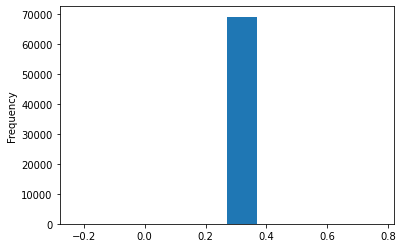

In [15]:
us_finance_firms['OPM'] = winsorize(us_finance_firms['OPM'], limits=[0.0001, 0.02])
us_finance_firms['OPM'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE OPM, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y MUY POCOS VALORES ALCANZAN LOS -7000, DEMOSTRANDONOS QUE HAY BASTANTE SESGO

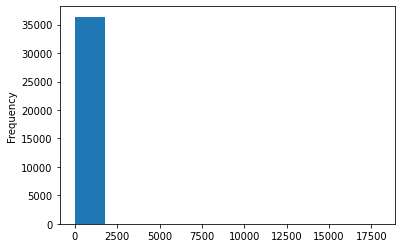

In [16]:
us_finance_firms['Book-to-market ratio'] = winsorize(us_finance_firms['Book-to-market ratio'], limits=[0.0001, 0.02])
us_finance_firms['Book-to-market ratio'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE BOOK TO MARKET RATIO, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y LOS DEMÁS SE TIENEN UN SESGO DE -0.5 A 1E11.

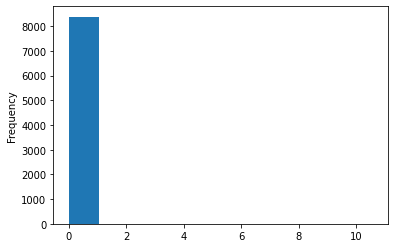

In [17]:
us_finance_firms['Short financial leverage'] = winsorize(us_finance_firms['Short financial leverage'], limits=[0.0001, 0.02])
us_finance_firms['Short financial leverage'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE SHORT FINANCIAL LEVERAGE, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y LOS DEMÁS SE SESGAN UN POCO HASTA 0.4.

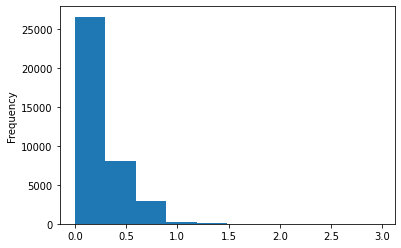

In [18]:
us_finance_firms['Long financial leverage'] = winsorize(us_finance_firms['Long financial leverage'], limits=[0.0001, 0.02])
us_finance_firms['Long financial leverage'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE LONG FINANCIAL LEVERAGE, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y LOS DEMÁS SE SESGAN UN POCO HASTA 0.8.

In [19]:
us_finance_firms[['OPM', 'Book-to-market ratio', 'Short financial leverage', 'Long financial leverage']].describe()

,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage
count,6.912300e+04,36397.000000,8393.000000,37841.000000
mean,2.704487e-01,1.341559,0.061086,0.206884
std,1.110231e-16,94.174495,0.298713,0.238992
min,2.704487e-01,-4.333951,0.000000,0.000000
25%,2.704487e-01,0.473138,0.000000,0.023432
50%,2.704487e-01,0.734767,0.004291,0.089712
75%,2.704487e-01,1.018940,0.034598,0.389809
max,2.704487e-01,17966.755978,10.584722,2.972546


- Design and run a multiple regression model to examine whether your selected factors and earnings per share deflated by price can explain/predict annual stock returns. You have to control for industry and firm size. To control for these variables you have to include them as extra independent variables in the model
    - Your independent variables must be in the right scale so that you can compare the values of the variables among different firms of any size
    - For each independent variable you have to check for outliers and do the corresponding adjustments to avoid unreliable results in your regression model
    - You must check for possible multicollinearity problems. Briefly explain what is multicollinearity, run and interpret the corresponding test

In [21]:
us_finance_firms = us_finance_firms.dropna()

def dense_inclusive_pct(x):
    # I subtract one to handle the inclusive bit
    r = x.rank(method='dense') - 1
    return r / r.max() * 100

us_finance_firms['percentile'] = us_finance_firms.groupby('q')['Market value'].apply(dense_inclusive_pct).astype(int)

us_finance_firms["Small"] = us_finance_firms['percentile'] <= 33
us_finance_firms["Small"] = us_finance_firms["Small"].astype(int)

us_finance_firms["Medium"] = (us_finance_firms['percentile'] <= 66) & (us_finance_firms['percentile'] > 33) 
us_finance_firms["Medium"] = us_finance_firms["Medium"].astype(int)

us_finance_firms.drop('percentile', axis=1)

revenue    cogs     sgae  otheropexp  extraincome   finexp  \
firm q                                                                    
AC   2016q4  16295.0     0.0  16163.0         0.0      -5392.0 -10010.0   
     2017q1   4987.0     0.0   9319.0         0.0      -4956.0  12214.0   
     2017q2   5095.0     0.0  11548.0         0.0        -30.0 -10769.0   
     2017q3   5248.0     0.0  11360.0         0.0        186.0  -7512.0   
     2017q4  11585.0     0.0  15074.0         0.0        731.0 -24805.0   
...              ...     ...      ...         ...          ...      ...   
XELB 2021q1   7809.0  1835.0   8300.0       160.0         81.0    280.0   
     2021q2  10764.0  3063.0   8987.0       431.0       -665.0    522.0   
     2021q3  11261.0  2865.0   9539.0       163.0        200.0    565.0   
     2021q4   8098.0  2904.0  10903.0      1338.0       -430.0    553.0   
     2022q1   8747.0  1680.0  10065.0        32.0        251.0    708.0   

             incometax  totalassets  totalliabilities  shortdebt  ...  \
firm q                                                            ...   
AC   2016q4     1103.0     952603.0           78581.0        0.0  ...   
     2017q1    -8424.0     917633.0           35802.0        0.0  ...   
     2017q2     -310.0     926837.0           39917.0        0.0  ...   
     2017q3       67.0     979519.0           81311.0        0.0  ...   
     2017q4     6247.0    1006915.0           88768.0        0.0  ...   
...                ...          ...               ...        ...  ...   
XELB 2021q1     -138.0     121815.0           38019.0     4427.0  ...   
     2021q2    -1346.0     134176.0           51834.0     5720.0  ...   
     2021q3     -535.0     131203.0           49136.0     6313.0  ...   
     2021q4    -1087.0     125781.0           50839.0     3707.0  ...   
     2022q1        0.0     123709.0           52476.0     3545.0  ...   

              revenue sum       OPM  Book-to-market ratio  \
firm q                                                      
AC   2016q4  3.250558e+10  0.270449              1.049927   
     2017q1  3.250558e+10  0.270449              1.005917   
     2017q2  3.250558e+10  0.270449              1.093098   
     2017q3  3.250558e+10  0.270449              1.054295   
     2017q4  3.250558e+10  0.270449              1.136004   
...                   ...       ...                   ...   
XELB 2021q1  3.250558e+10  0.270449              2.186223   
     2021q2  3.250558e+10  0.270449              1.424936   
     2021q3  3.250558e+10  0.270449              2.818721   
     2021q4  3.250558e+10  0.270449              3.515251   
     2022q1  3.250558e+10  0.270449              2.442752   

             Short financial leverage  Long financial leverage      EPSP  \
firm q                                                                     
AC   2016q4                  0.000000                 0.000000  0.010858   
     2017q1                  0.000000                 0.000000 -0.009265   
     2017q2                  0.000000                 0.000000  0.005701   
     2017q3                  0.000000                 0.000000  0.001565   
     2017q4                  0.000000                 0.000000  0.018645   
...                               ...                      ...       ...   
XELB 2021q1                  0.036342                 0.183303 -0.068564   
     2021q2                  0.042631                 0.213883 -0.015453   
     2021q3                  0.048116                 0.209812 -0.045887   
     2021q4                  0.029472                 0.260636 -0.305501   
     2022q1                  0.028656                 0.258356 -0.128185   

                    R       F1R Small Medium  
firm q                                        
AC   2016q4  0.077599  0.261086     0      1  
     2017q1  0.261086  0.176091     0      1  
     2017q2  0.176091  0.012676     0      1  
     2017q3  0.012676  0.046230     0      1  
     2017q4  0.046230 

__NOTA:__ EL MÉTODO DE WINSORIZACIÓN PARA ENCARGARNOS DE LOS OUTLIERS, SE REALIZARON PREVIAMENTE.

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()

vif  = us_finance_firms[["F1R", "EPSP", "OPM", 'Short financial leverage', 'Long financial leverage']]

vif_data["feature"] = vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif.values, i) for i in range(len(vif.columns))]

print(vif_data)

                    feature       VIF
0                       F1R  1.035832
1                      EPSP  1.042096
2                       OPM  2.303579
3  Short financial leverage  1.018046
4   Long financial leverage  1.025814


CON LOS DATOS OBTENIDOS  TRAS CALCULAR EL VIF (VARIANCE INFLATION FACTO) EN LA PARTE DE ARRIBA CONSIDERANDO QUE PARA CADA VARIABLE COMO NÚMERO LIMITE EL 10, PODEMOS SABER QUE NO HAY MULTICOLINEARIDAD PARA NINGUNA DE LA MEDIDAS SELECCIONADAS PARA EL MODELO, POR LO QUE NO SERÁ NECESARIO ELIMINAR NINGUNA VARIABLE.

- Interpret your model
    - Interpret the results of each coefficient (beta and their statistical significance)
    - Interpret the R-squared of the model

In [23]:
# Getting x and y parameters for the model prediction
x = us_finance_firms[['EPS', 'OPM', 'EPSP', 'Book-to-market ratio', 'Short financial leverage', 'Long financial leverage', 'Small', 'Medium']]
y = us_finance_firms['F1R']

# Getting information to interpret a model
x = sm.add_constant(x)
results = sm.OLS(y, x, missing="drop").fit()
pred = results.predict(x)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    F1R   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     72.22
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          2.49e-101
Time:                        10:31:43   Log-Likelihood:                -4273.0
No. Observations:                7064   AIC:                             8562.
Df Residuals:                    7056   BIC:                             8617.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
EPS                     

INTERPRETACIÓN DEL MODELO OBTENIDO:

NUESTRA VARIABLE DEPENDIENTE EN ESTE CASO FUERON LOS RETORNOS DE LOS STOCK 1 TRIMESTRE EN EL FUTURO TOMANDO COMO VARIABLES INDEPENDIENTES LOS EPS (EARNINGS PER SHARE), OPM (OPERATING PROFIT MARGIN), BOOK TO MARKET RATIO, SHORT FINANCIAL LEVERAGE, LONG FINANCIAL LEVERAGE Y SIZE QUE ES EL TAMAÑO DE INDUSTRIA EN BASE AL MARKET VALUE SEPARADO EN TRES CATEGORIAS (SMALL, MEDIUM Y BIG).

CON BASE A LO PRESENTE EN NUESTRO MODELO DE PREDICCIÓN PODEMOS DECIR:

- __SOBRE EPS (EARNINGS PER SHARE)__:


- __SOBRE EPSP (EARNINGS PER SHARE DEFLATED BY PRICE)__: 
    - ES LA VARIABLE MÁS EXPLICATIVA EN EL MODELO, ESTO PODEMOS SABERLO PORQUE SU T-VALUE ES LA QUE POSEE EL VALOR MÁS GRANDE, YA QUE ES LA QUE NOS DICE LA DISTANCIA DE LA BETA REAL A SU VALOR NULO EN DESVIACIONES ESTÁNDAR. 
    - TAMBIÉN PODEMOS DECIR QUE LOS CAMBIOS EN LA VARIABLE DEPENDIENTE TIENE UNA MAYOR SENSIBILIDAD CON RESPECTO A LOS EPSP,   ESTO PODEMOS SABERLO PORQUE ES LA QUE TIENE UN VALOR MÁS GRANDO EN SU COEFICIENTE.


- __SOBRE OPM (OPERATING PROFIT MARGIN)__:


- __SOBRE Book-to-market ratio__:


- __SOBRE Short financial leverage__:


- __SOBRE Long financial leverage__:


POR EL VALOR OBTENIDO EN LA R^2 QUE ES DE 0.075, CON LO QUE PODEMOS SABER QUE LA PRECISIÓN DEL MODELO GENERADO ES DE APROXIMADAMENTE 7.5%, CON LO QUE PODEMOS DECIR QUE ES MUY BAJO.

LOS COEFICIENTE PARA LAS DIFERENTES TAMAÑOS DE EMPRESA SON:
- SMALL: # + #(EPS) + #(OPM) + #(EPSP) #(Book-to-market ratio) + #(Short financial leverage ) + #(Long financial leverage)
- MEDIUM: # + #(EPS) + #(OPM) + #(EPSP) + #(Book-to-market ratio) + #(Short financial leverage ) + #(Long financial leverage)
- BIG: # + #(EPS) + #(OPM) + #(EPSP) + #(Book-to-market ratio) + #(Short financial leverage ) + #(Long financial leverage)

<br>

- Adjustments to your model. If there is one or more independent variables (factors or control variables) that were not significant, drop them from your model. You have to run and interpret your final model.

In [24]:
# Getting x and y parameters for the model prediction
x = us_finance_firms[['EPS', 'OPM', 'EPSP', 'Book-to-market ratio', 'Long financial leverage', 'Small', 'Medium']]
y = us_finance_firms['F1R']

# Getting information to interpret a model
x = sm.add_constant(x)
results = sm.OLS(y, x, missing="drop").fit()
pred = results.predict(x)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    F1R   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     83.97
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          5.98e-102
Time:                        10:31:47   Log-Likelihood:                -4273.8
No. Observations:                7064   AIC:                             8562.
Df Residuals:                    7057   BIC:                             8610.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
EPS                       

ELIMINANDO LA VARIABLE INDEPENDIENTE MENOS SIGNIFICATIVA, PODEMOS VER QUE NUESTRO MODELO NO TUVO CAMBIOS SIGNIFICATIVOS, YA QUE EL VALOR DE NUESTRA R^2 SE MANTUVO IGUAL.